# 2. Q-Learning

## 2.1 Learning from experts

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from tic_env import TictactoeEnv
from Q_learning import eps_policy, eps_policy_self_practice
from tqdm.notebook import tqdm
import pickle
env = TictactoeEnv()
Train=True

In [2]:
if Train:
    eps_agents = np.arange(0,1,0.1)
    rewards = []
    for eps_agent in eps_agents:
        print('Started learning with eps_agent={:.1f}'.format(eps_agent))
        _, rewards_250 = eps_policy(env, Q_table=dict(), eps_agent=eps_agent)
        rewards.append(rewards_250)

    with open("./rewards/q1", "wb") as fp:
        pickle.dump((eps_agents, rewards), fp)
else:
    with open("./rewards/q1", "rb") as fp:
        eps_agents, rewards = pickle.load(fp)


Started learning with eps_agent=0.0
Learning finished after 41.57s
Played a total of 20000 games
Started learning with eps_agent=0.1
Learning finished after 46.78s
Played a total of 20000 games
Started learning with eps_agent=0.2
Learning finished after 44.72s
Played a total of 20000 games
Started learning with eps_agent=0.3
Learning finished after 42.74s
Played a total of 20000 games
Started learning with eps_agent=0.4
Learning finished after 41.28s
Played a total of 20000 games
Started learning with eps_agent=0.5
Learning finished after 42.58s
Played a total of 20000 games
Started learning with eps_agent=0.6
Learning finished after 42.93s
Played a total of 20000 games
Started learning with eps_agent=0.7
Learning finished after 43.40s
Played a total of 20000 games
Started learning with eps_agent=0.8
Learning finished after 39.39s
Played a total of 20000 games
Started learning with eps_agent=0.9
Learning finished after 39.31s
Played a total of 20000 games


#### Question 1: Plot the average reward after every 250 games with different agent eps in [0, 1)

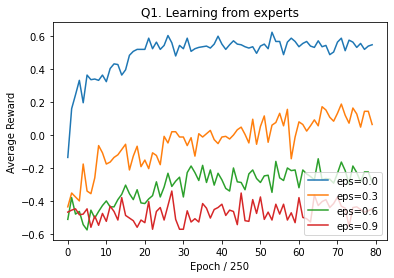

In [3]:
indices = [0, 3, 6, 9] #Corresponds to 0.0, 0.3, 0.6 and 0.9
for ind in indices:
    plt.plot(rewards[ind], label='eps={:.1f}'.format(eps_agents[ind]))
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Q1. Learning from experts')
plt.legend(loc='lower right')
# txt="Average rewards after every 250 games with different values for the exploration rate of the agent"
# plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig('./plots/q1.png')
plt.show()


### 2.1.1 Decreasing exploration

In [4]:
if Train:
    expl_games = [1, 10, 100, 1000, 5000, 10000, 20000, 40000]
    expl_rewards = []
    for nb_expl_games in expl_games:
        print('Started learning with expl_games={}'.format(nb_expl_games))
        _, rewards_expl_250 = eps_policy(env, Q_table=dict(), decay_eps=True, expl_games=nb_expl_games)
        expl_rewards.append(rewards_expl_250)

    with open("./rewards/q2", "wb") as fp:
        pickle.dump((expl_rewards, expl_games), fp)
else:
    with open("./rewards/q2", "rb") as fp:
        expl_rewards, expl_games = pickle.load(fp)


Started learning with expl_games=1
Learning finished after 46.14s
Played a total of 20000 games
Started learning with expl_games=10
Learning finished after 45.19s
Played a total of 20000 games
Started learning with expl_games=100
Learning finished after 45.02s
Played a total of 20000 games
Started learning with expl_games=1000
Learning finished after 48.79s
Played a total of 20000 games
Started learning with expl_games=5000
Learning finished after 44.84s
Played a total of 20000 games
Started learning with expl_games=10000
Learning finished after 44.39s
Played a total of 20000 games
Started learning with expl_games=20000
Learning finished after 40.68s
Played a total of 20000 games
Started learning with expl_games=40000
Learning finished after 42.88s
Played a total of 20000 games


#### Question 2: Plot the average reward after every 250 games with different numbers of exploratory games

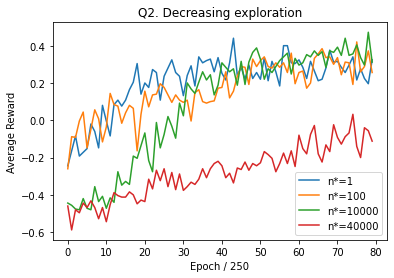

In [5]:
indices = [0, 2, 5, 7]
for ind in indices:
    plt.plot(expl_rewards[ind], label='n*={}'.format(expl_games[ind]))
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Q2. Decreasing exploration')
# plt.title('Average rewards after every 250 games with different values of n*')
plt.legend()
plt.savefig('./plots/q2.png')
plt.show()

#### Question 3: Compute 'test' M_opt and M_rand after every 250 games 

In [6]:
if Train:
    expl_games = [1, 10, 100, 1000, 5000, 10000, 20000, 40000]
    eps_vs_opt_rewards = []
    eps_vs_rnd_rewards = []
    for nb_expl_games in expl_games:
        print('Started learning with expl_games={}'.format(nb_expl_games))
        _, M_opts, M_rnds = eps_policy(env, Q_table=dict(), decay_eps=True, expl_games=nb_expl_games, test_opt_vs_rnd=True)
        eps_vs_opt_rewards.append(M_opts)
        eps_vs_rnd_rewards.append(M_rnds)

    with open("./rewards/q3", "wb") as fp:
        pickle.dump((eps_vs_opt_rewards, eps_vs_rnd_rewards, expl_games), fp)
else:
    with open("./rewards/q3", "rb") as fp:
        eps_vs_opt_rewards, eps_vs_rnd_rewards, expl_games = pickle.load(fp)



Started learning with expl_games=1
Learning finished after 227.26s, played 20000 games
Started learning with expl_games=10
Learning finished after 217.33s, played 20000 games
Started learning with expl_games=100
Learning finished after 220.91s, played 20000 games
Started learning with expl_games=1000
Learning finished after 240.10s, played 20000 games
Started learning with expl_games=5000
Learning finished after 234.27s, played 20000 games
Started learning with expl_games=10000
Learning finished after 222.84s, played 20000 games
Started learning with expl_games=20000
Learning finished after 209.95s, played 20000 games
Started learning with expl_games=40000
Learning finished after 213.34s, played 20000 games


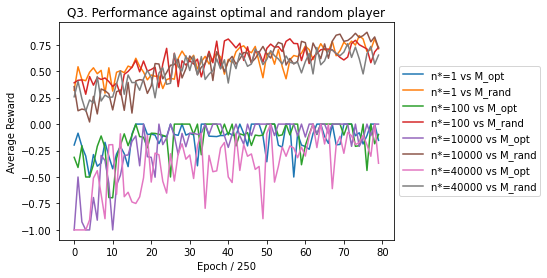

In [8]:
indices = [0, 2, 5, 7]
for ind in indices:
    plt.plot(eps_vs_opt_rewards[ind], label='n*={} vs M_opt'.format(expl_games[ind]))
    plt.plot(eps_vs_rnd_rewards[ind], label='n*={} vs M_rand'.format(expl_games[ind]))
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Q3. Performance against optimal and random player')
plt.savefig('./plots/q3.png', bbox_inches='tight')
plt.show()

### 2.1.2 Good expoerts and bad experts

In [9]:
best_expl_games = 10000

#### Question 4: Test best n* against optimal with different exploration level

In [10]:
if Train:
    eps_opts = np.arange(0,1,0.1)
    eps_rewards = []
    eps_vs_opt_rewards = []
    eps_vs_rnd_rewards = []
    for eps_opt in eps_opts:
        print('Started learning with eps_opt={:.1f}'.format(eps_opt))
        _, M_opts, M_rnds = eps_policy(env, Q_table=dict(), eps_opt=eps_opt, decay_eps=True, expl_games=best_expl_games, test_opt_vs_rnd=True)
        eps_vs_opt_rewards.append(M_opts)
        eps_vs_rnd_rewards.append(M_rnds)

    with open("./rewards/q4", "wb") as fp:
        pickle.dump((eps_vs_opt_rewards, eps_vs_rnd_rewards, eps_opts), fp)
else:
    with open("./rewards/q4", "rb") as fp:
        eps_vs_opt_rewards, eps_vs_rnd_rewards, eps_opts = pickle.load(fp)

Started learning with eps_opt=0.0
Learning finished after 240.10s, played 20000 games
Started learning with eps_opt=0.1
Learning finished after 336.30s, played 20000 games
Started learning with eps_opt=0.2
Learning finished after 232.05s, played 20000 games
Started learning with eps_opt=0.3
Learning finished after 308.83s, played 20000 games
Started learning with eps_opt=0.4
Learning finished after 213.03s, played 20000 games
Started learning with eps_opt=0.5
Learning finished after 237.53s, played 20000 games
Started learning with eps_opt=0.6
Learning finished after 231.31s, played 20000 games
Started learning with eps_opt=0.7
Learning finished after 216.92s, played 20000 games
Started learning with eps_opt=0.8
Learning finished after 192.31s, played 20000 games
Started learning with eps_opt=0.9
Learning finished after 184.01s, played 20000 games


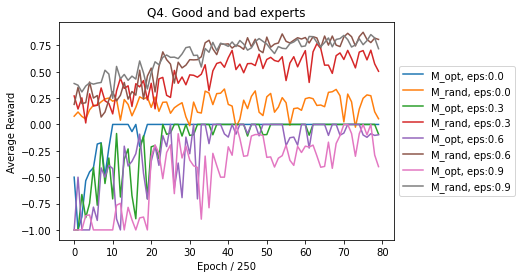

In [11]:
indices=[0, 3, 6, 9]
for ind in indices:
    plt.plot(eps_vs_opt_rewards[ind], label='M_opt, eps:{:.1f}'.format(eps_opts[ind]))
    plt.plot(eps_vs_rnd_rewards[ind], label='M_rand, eps:{:.1f}'.format(eps_opts[ind]))
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Q4. Good and bad experts')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.savefig('./plots/q4.png', bbox_inches='tight')
plt.show()

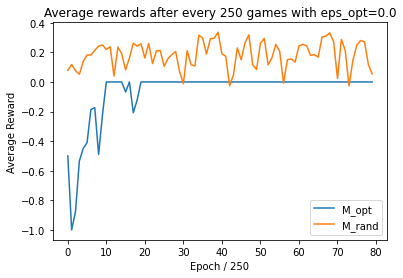

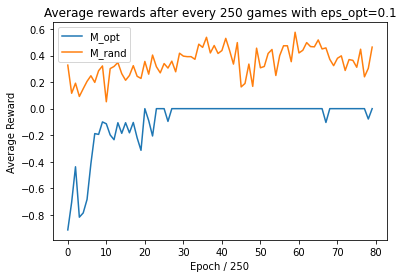

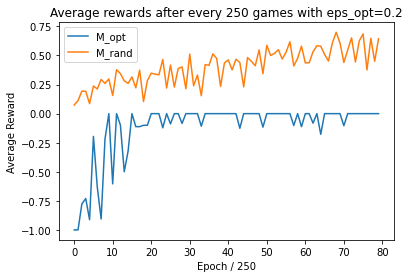

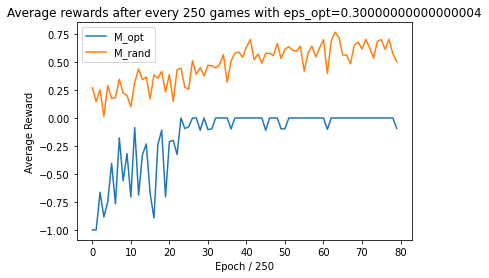

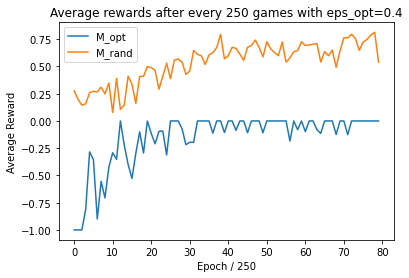

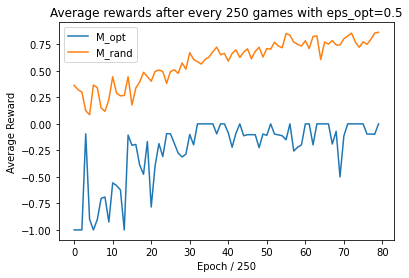

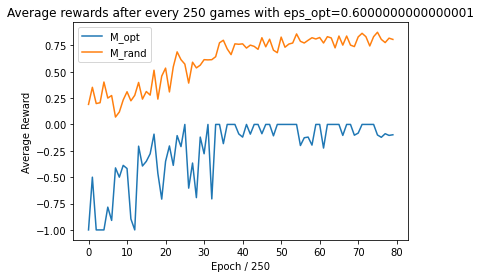

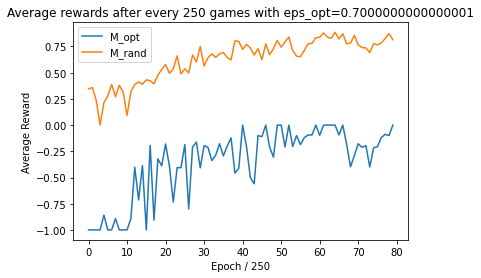

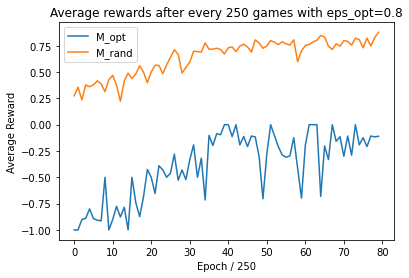

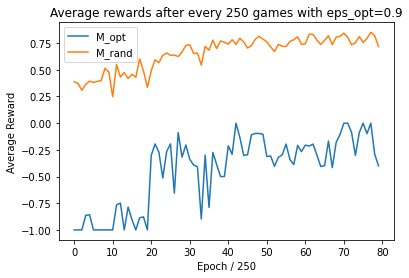

In [12]:
for idx, eps_opt in enumerate(eps_opts):
    plt.plot(eps_vs_opt_rewards[idx], label='M_opt')
    plt.plot(eps_vs_rnd_rewards[idx], label='M_rand')
    plt.legend()
    plt.xlabel('Epoch / 250')
    plt.ylabel('Average Reward')
    plt.title('Average rewards after every 250 games with eps_opt={}'.format(eps_opt))
    plt.show()

#### Question 5: What are the highest values of M_opt and M_rand achieved after 20 000 games ?

In [13]:
print('Best M_opt after 20000 games: {:.3f}'.format(np.max(eps_vs_opt_rewards)))
print('Best M_rnd after 20000 games: {:.3f}'.format(np.max(eps_vs_rnd_rewards)))

Best M_opt after 20000 games: 0.000
Best M_rnd after 20000 games: 0.886


The highest $\begin{aligned}M_{opt}\end{aligned}$ is equal to 0. This is normal and to be awaited since if correctly played, a player never losses. Thus the optimal player will never loose. If now the agent has played and learned enough, then he will also never loose. This will result in all games ending in a draw.

The highest $\begin{aligned}M_{rand}\end{aligned}$ is equal to 0.882. This value is pretty high but is not out of the ordinary since if correctly played, a player never losses. Thus the optimal player will never loose. If now the agent has played and learned enough, then he will also never loose. This will result in all games ending in either a win for the agent or a draw.



#### Question 6: Agent 1 learns by playing against Opt(0) and finds optimal Q1(s,a). Agent 2 learns by playing against Opt(1) and finds optimal Q2(s,a). Do Q1(s, a) and Q2(s, a) have the same values?

The answer is no. Since Agent 1 plays against an optimal player who always chooses the best action, the game always ends in either a draw or a loose for Agent 1. This means that all the Q-values of Agent 1 will be smaller or equal 0 since the only possibility to obtain a positive reward is by winning a game. On the other hand, Agent 2 will win most of its games and never loose once he has learned the optimal Q-values. Thus he will have Q-values that are greater then 0.

### Learning by self-practive

#### Question 7:  Plot the average reward for the self-practive after every 250 games with different agent eps in [0, 1) 

In [14]:
if Train:
    eps_agents = np.arange(0, 1, 0.1)
    eps_vs_opt_rewards = []
    eps_vs_rnd_rewards = []
    for eps_agent in tqdm(eps_agents):
        print('Started learning with eps_opt={:.1f}'.format(eps_agent))
        _, M_opts, M_rnds = eps_policy_self_practice(env, Q_table=dict(), eps_agents=eps_agent)
        eps_vs_opt_rewards.append(M_opts)
        eps_vs_rnd_rewards.append(M_rnds)

    with open("./rewards/q7", "wb") as fp:
        pickle.dump((eps_vs_opt_rewards, eps_vs_rnd_rewards, eps_agents), fp)
else:
    with open("./rewards/q7", "rb") as fp:
        eps_vs_opt_rewards, eps_vs_rnd_rewards, eps_agents = pickle.load(fp)





  0%|          | 0/10 [00:00<?, ?it/s]

Started learning with eps_opt=0.0


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 155.25s, played 20000 games
Started learning with eps_opt=0.1


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 182.83s, played 20000 games
Started learning with eps_opt=0.2


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 180.77s, played 20000 games
Started learning with eps_opt=0.3


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 186.12s, played 20000 games
Started learning with eps_opt=0.4


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 180.13s, played 20000 games
Started learning with eps_opt=0.5


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 171.07s, played 20000 games
Started learning with eps_opt=0.6


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 180.13s, played 20000 games
Started learning with eps_opt=0.7


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 184.17s, played 20000 games
Started learning with eps_opt=0.8


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 196.98s, played 20000 games
Started learning with eps_opt=0.9


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 195.59s, played 20000 games


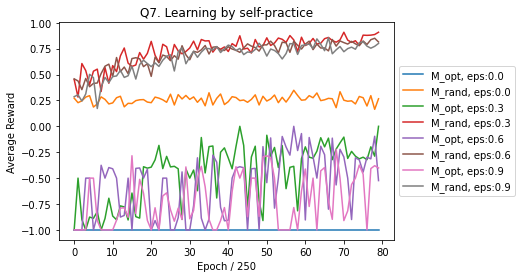

In [15]:
indices=[0, 3, 6, 9]
for ind in indices:
    plt.plot(eps_vs_opt_rewards[ind], label='M_opt, eps:{:.1f}'.format(eps_opts[ind]))
    plt.plot(eps_vs_rnd_rewards[ind], label='M_rand, eps:{:.1f}'.format(eps_opts[ind]))
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Q7. Learning by self-practice')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.savefig('./plots/q7.png', bbox_inches='tight')
plt.show()

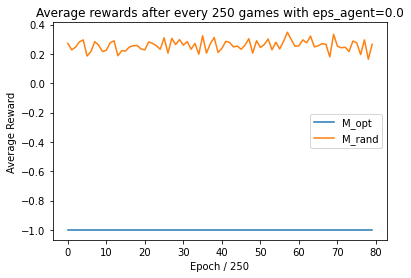

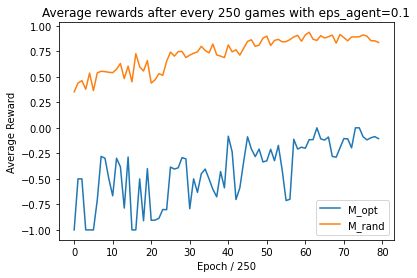

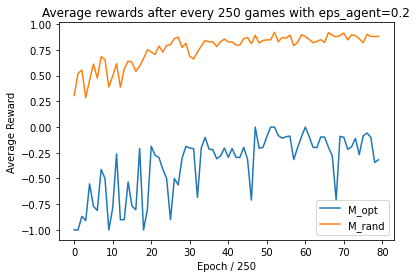

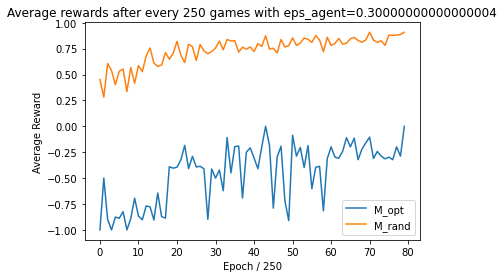

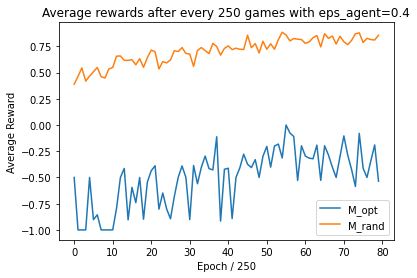

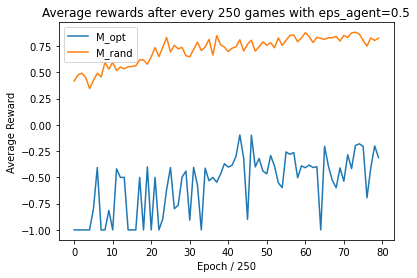

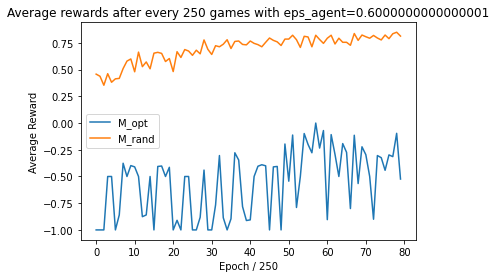

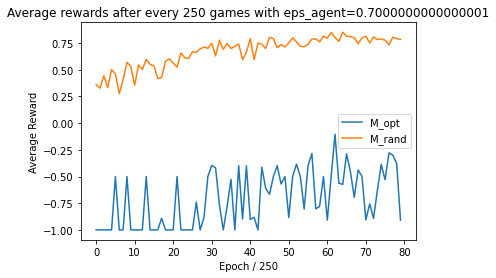

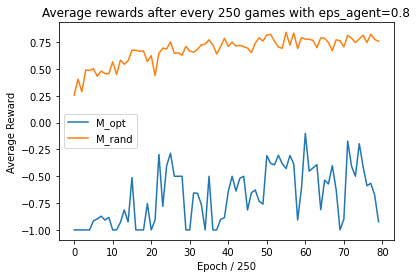

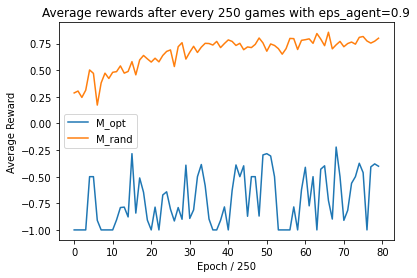

In [16]:
for idx, eps_agent in enumerate(eps_agents):
    plt.plot(eps_vs_opt_rewards[idx], label='M_opt')
    plt.plot(eps_vs_rnd_rewards[idx], label='M_rand')
    plt.legend()
    plt.xlabel('Epoch / 250')
    plt.ylabel('Average Reward')
    plt.title('Average rewards after every 250 games with eps_agent={}'.format(eps_agent))
    plt.show()

#### Question 8: Plot the average reward after every 250 games with different values of exploration games

In [6]:
if Train:
    expl_games = [1, 10, 100, 1000, 5000, 10000, 20000, 40000]
    eps_vs_opt_rewards = []
    eps_vs_rnd_rewards = []
    for expl_game in tqdm(expl_games):
        print('Started learning with expl_game={:.1f}'.format(expl_games))
        _, M_opts, M_rnds = eps_policy_self_practice(env, Q_table=dict(), decay_eps=True, expl_games=expl_game)
        eps_vs_opt_rewards.append(M_opts)
        eps_vs_rnd_rewards.append(M_rnds)

    with open("./rewards/q8", "wb") as fp:
        pickle.dump((eps_vs_opt_rewards, eps_vs_rnd_rewards, expl_games), fp)
else:
    with open("./rewards/q8", "rb") as fp:
        eps_vs_opt_rewards, eps_vs_rnd_rewards, expl_games = pickle.load(fp)

  0%|          | 0/8 [00:00<?, ?it/s]

Started learning with eps_opt=0.9


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 223.69s
Played a total of 20000 games
Started learning with eps_opt=0.9


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 225.56s
Played a total of 20000 games
Started learning with eps_opt=0.9


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 224.15s
Played a total of 20000 games
Started learning with eps_opt=0.9


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 222.68s
Played a total of 20000 games
Started learning with eps_opt=0.9


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 221.91s
Played a total of 20000 games
Started learning with eps_opt=0.9


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 216.70s
Played a total of 20000 games
Started learning with eps_opt=0.9


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 213.02s
Played a total of 20000 games
Started learning with eps_opt=0.9


  0%|          | 0/20000 [00:00<?, ?it/s]

Learning finished after 201.97s
Played a total of 20000 games


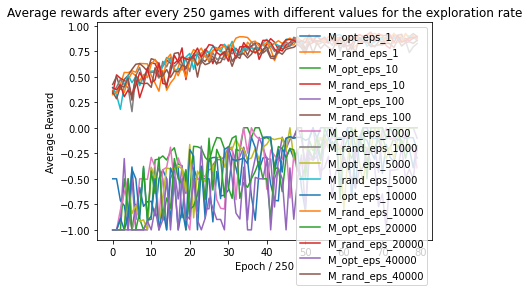

In [12]:
indices=[1, 100, 10000, 40000]
for ind in indices:
    plt.plot(eps_vs_opt_rewards[ind], label='M_opt_eps_{}'.format(ind))
    plt.plot(eps_vs_rnd_rewards[ind], label='M_rand_eps_{}'.format(ind))
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.legend()
plt.title('Average rewards after every 250 games with different values for the exploration rate')
plt.savefig('./plots/q8.png')
plt.show()

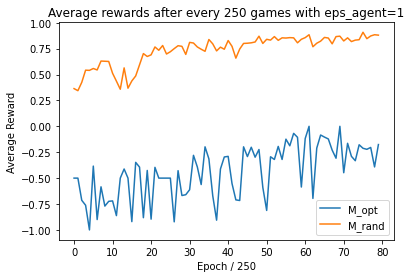

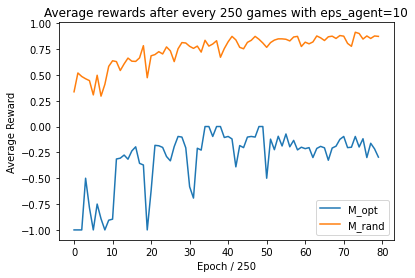

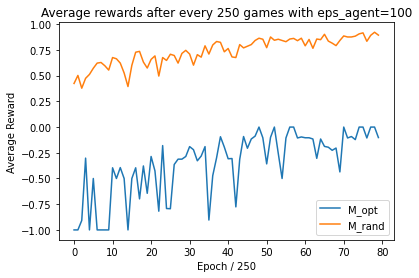

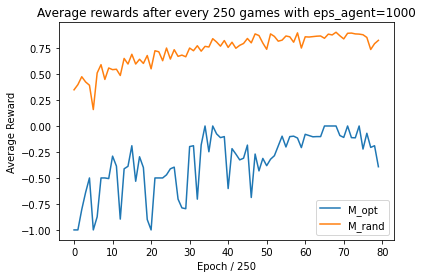

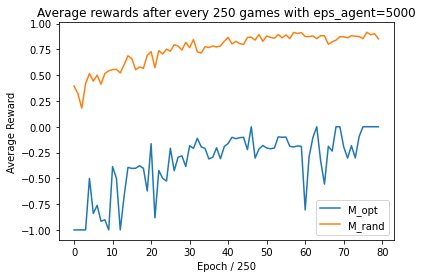

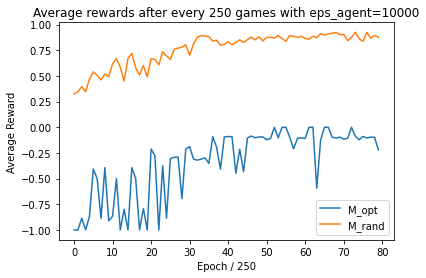

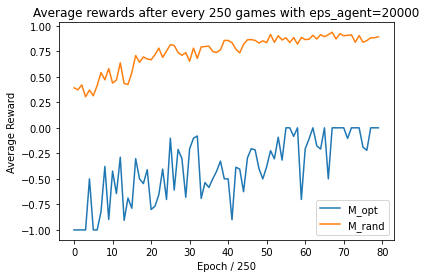

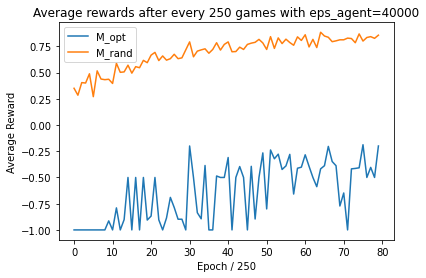

In [13]:
for idx, expl_game in enumerate(expl_games):
    plt.plot(eps_vs_opt_rewards[idx], label='M_opt')
    plt.plot(eps_vs_rnd_rewards[idx], label='M_rand')
    plt.legend()
    plt.xlabel('Epoch / 250')
    plt.ylabel('Average Reward')
    plt.title('Average rewards after every 250 games with n*={}'.format(expl_game))
    plt.show()

#### Question 9: What are the highest values for Mopt and Mrand achieved after 20 000 games?

In [17]:
best_M_opt = max(max(eps_vs_opt_rewards))
best_M_rand = max(max(eps_vs_rnd_rewards))
print('Best M_opt: {}'.format(best_M_opt))
print('Best M_rand: {:.4f}'.format(best_M_rand))

Best M_opt: 0.0
Best M_rand: 0.9220


#### Question 10: 

In [ ]:
q, m_opt, m_rnd = eps_policy_self_practice(env, Q_table=dict(), nb_epochs=20000, eps_agent=0.2)
plt.plot(m_opt, label='M_opt')
plt.plot(m_rnd, label='M_rand')
plt.legend()
plt.xlabel('Epoch / 250')
plt.ylabel('Average Reward')
plt.title('Average rewards after every 250 games')
plt.show()